In [2]:
from __future__ import annotations

import random
from typing import Any

import numpy as np
from gym import Env
from gym.spaces import Box
from gym.spaces import Discrete
from numpy.typing import NDArray

import numpy as np
import matplotlib.pyplot as plt

# Planning

## Task List
- ~~Drill multiple wells, one after the other and not to update the environment after every simulation.~~
- ~~Make sure well/wells dont crash into each other/itself or any faults/artifacts~~
- ~~Avoid 180 degree turns~~
- Have a target zone where the well eventually want to make it to and get higher reward
- Use a metric like MSE/UCS to get an estimate on the amount of energy required to drill and optimizing it to have lowest energy usage (also tie in the economic constraints)

## Action Space
- Surface Location ?? Pick it randomly or intentionally?
- Number of wells to drill
- Bit Movement
    -  Up
    -  Down
    -  Left
    -  Right
    -  Angle ?? If the grid size is as much as a stand then the max angle should be around 3 degrees 

## Observation Space

Same shape [matrix] as the input. Ideally 30 ft by 30 ft to match with the drilling pipe (90 ft by 90 ft for stand). Bool with true for wherever well is located.

## Possible Rewards
- While Drilling
    -  Proximity to Reservoir (based on the percentage of Normalized TOC?) - *Positive Reward*
    -  Proximity to Fault - *VERY HIGH Negative Reward*
    -  Proximity to itself or other wells - *VERY HIGH Negative Reward*
    -  Proximity to the possible depletion zone of an existing well - *VERY HIGH Negative Reward*
    -  Remaining oil in the zone of the well - *High Positive Reward*

- After Drilling
    -  Total UCS/MSE it was drilled through - *Negative Reward based on the UCS total, can also relate it to a USD amount*    
    -  Total Well Length - *Negative Reward based on the pipe count, can also relate it to a USD amount* 

# Simple Environment

In [3]:
class SimpleDriller(Env):  # type: ignore
    """Simple driller environment."""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        self.model = np.loadtxt(
            env_config["model_path"],
            delimiter=env_config["delim"],
        )

        self.nrow, self.ncol = self.model.shape
        self.available_pipe = env_config["available_pipe"]

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []

        self.action_space = Discrete(4)

        self.observation_space = Box(
            low=0, high=1, shape=(self.nrow, self.ncol), dtype="bool"
        )
        self.reset()

    def step(  # noqa: C901
        self, action: int
    ) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        done = False
        actions = {
            0: [1, 0],  # down
            1: [0, -1],  # left
            2: [0, 1],  # right
            3: [-1, 0],  # up
        }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            reward = -100

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            reward = -100

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 2
            self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            reward = 0

        if self.bit_location in self.trajectory[:-1]:
            done = True
            reward = -100

        info: dict[str, Any] = {}

        return self.state, reward, done, info

    def update_state(self) -> None:
        """Update state method."""
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")

    def reset(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        self.surface_hole_location = [1, random.randint(0, self.ncol - 1)]  # noqa: S311
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.bit_location = self.surface_hole_location
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        return self.state


# Multidriller Environment

In [4]:
class MultiDriller(Env):  # type: ignore
    """Simple driller environment for multiple wells"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])
        
        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]
            
        self.num_wells = env_config["num_wells"]
                
        
        self.wells_drilled = 0 
        self.reward = 0
        self.multi_reward = 0

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
        self.surface_location = []
        self.last_action = None
            
            
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
#         reward = 0
#         self.reset_well()
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            self.reward = -100
#             print('    Number of Rows exceeded')
#             reward = 0

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            self.reward = -100
#             print('    Number of Cols exceeded')
#             reward = 0

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 2
            if len(self.trajectory)>0:
                self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            self.reward = 0
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            done = True
            self.reward = -100
#             print('    Crashed onto itself')
#             reward = 0
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            done = True
            self.reward = -100
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
#                 done = True
                self.reward = -1000    
#                 print('    Immediate 180 degree turn')
    
        info: dict[str, Any] = {}
        
        if done:
            self.wells_drilled += 1            
            self.multi_reward += self.reward 
            
            if len(self.trajectory)>0:
                self.multi_trajectory.append(self.trajectory)
                
            self.reset_well()
            
            if self.wells_drilled < self.num_wells:
                    done = False            
                    
            return self.state, self.multi_reward, done, info
        else:
            self.last_action = action
#             print(f'Last action: {actions[self.last_action]}')
            return self.state, self.reward, done, info

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 

        # Log the surface locations already used
        self.surface_location.append(self.surface_hole_location[1])
        
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        return self.state


# Reward based on Proximity Environment

In [245]:
class RewardDriller(Env):  # type: ignore
    """Driller environment for multiple wells with rewards based on proximity to reservoir"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])
        
#         # Trial model inputs
#         self.model[0] = self.model[0]+989
        
        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]

        self.num_wells = env_config["num_wells"]
        
        
#         self.wells_drilled = 0 
        self.reward = 1
        self.multi_reward = 0
        self.last_action = None

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
            
        # Surface location cache
        self.surface_location = []
            
        # Cache previous trajectories after the well is done drilling    
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            self.multi_reward = -10
            done = True
#             print('    Number of Rows exceeded')

        elif newcol < 0 or newcol >= self.ncol:
            self.multi_reward = -10
            done = True
#             print('    Number of Cols exceeded')

        else:
        
            # +ve reward for going towards target
            self.reward = (self.model[newrow, newcol]*10)
#             print(self.reward)          
                
           # Stop the well if it goes through a fault or negative entity in the model     
            if self.reward < 0:
                self.multi_reward = -10  
                done = True
                print('    Crashed into fault in the model')
#                 print(self.reward)
                
            else:
                # +ve reward for using pipes 
                self.reward += (self.pipe_used*0.5)
                self.multi_reward += self.reward
                
                if len(self.trajectory) > 0:
                    self.update_state()
        
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        
        # Avoid going along the surface
        if ((self.bit_location != self.surface_hole_location) & 
            (self.bit_location[0] == 0)):
            self.multi_reward += -10
            done = True
#             print('    Going along the surface horizontally')
    
        if self.pipe_used == self.available_pipe:
            done = True
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            self.multi_reward += -10
            done = True
#             print('    Crashed onto itself')
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            self.multi_reward = -10
            done = True
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
                self.multi_reward += -10
                done = True
#                 print('    Immediate 180 degree turn')

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        info: dict[str, Any] = {}
            
        if done:
#             self.wells_drilled += 1 
            
            if len(self.trajectory) > 2:
                self.multi_trajectory.append(self.trajectory)
                
                # Cache the surface locations already used
                self.surface_location.append(self.surface_hole_location[1])
                
            self.reset_well()
            
            if len(self.multi_trajectory) < self.num_wells:
                    done = False            
        
        else:
            self.last_action = action
        
#         print(self.multi_reward)         
#         print(self.reward)         
#         print(done)        
        return self.state, self.multi_reward, done, info
                

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 
        
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        
        return self.state


# Test Environment

Beginning Drill Campaign: 1
    Total Reward: 0.5
    Total Reward: 2.0
    Total Reward: 5.0
    Total Reward: -10
    Total Reward: -10
    Total Reward: -10


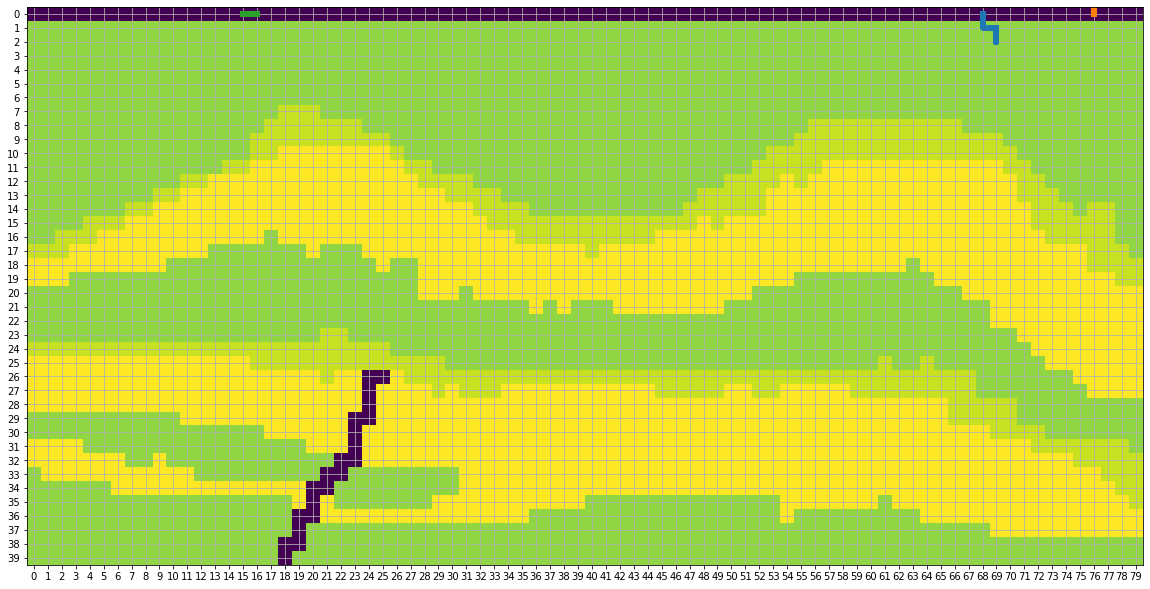

In [120]:
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")

env = RewardDriller(env_config)

episodes = 1

actions = {
           0: [1, 0],  # down
           1: [0, -1],  # left
           2: [0, 1],  # right
           3: [-1, 0],  # up
          }
plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

for episode in range(1,episodes+1):
    
    state = env.reset()
    done = False
    reward = 0
    
    print("Beginning Drill Campaign:", episode)
    
    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        print(f"    Total Reward: {reward}")

    for i in range(0,env.num_wells):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

# Train the Agent

## PPO

In [265]:
from stable_baselines3 import PPO

# More the number of wells, more time to train 
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
env = RewardDriller(env_config)

ppo = PPO("MlpPolicy", env, verbose=1)
ppo.learn(total_timesteps = 1000_000, log_interval=10)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------------
| time/                   |              |
|    fps                  | 666          |
|    iterations           | 10           |
|    time_elapsed         | 30           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0042662704 |
|    clip_fraction        | 0.115        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.422       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.5e+04      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.018       |
|    value_loss           | 3.09e+04     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 647           |


--------------------------------------
| time/                   |          |
|    fps                  | 628      |
|    iterations           | 120      |
|    time_elapsed         | 390      |
|    total_timesteps      | 245760   |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.00048 |
|    explained_variance   | 5.96e-08 |
|    learning_rate        | 0.0003   |
|    loss                 | 667      |
|    n_updates            | 1190     |
|    policy_gradient_loss | -3e-05   |
|    value_loss           | 1.58e+03 |
--------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 628           |
|    iterations           | 130           |
|    time_elapsed         | 423           |
|    total_timesteps      | 266240        |
| train/                  |       

---------------------------------------
| time/                   |           |
|    fps                  | 627       |
|    iterations           | 240       |
|    time_elapsed         | 783       |
|    total_timesteps      | 491520    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.86e-05 |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 1.51e-07  |
|    n_updates            | 2390      |
|    policy_gradient_loss | 0         |
|    value_loss           | 3.86e-07  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 626       |
|    iterations           | 250       |
|    time_elapsed         | 816       |
|    total_timesteps      | 512000    |
| train/                  |           |


---------------------------------------
| time/                   |           |
|    fps                  | 622       |
|    iterations           | 360       |
|    time_elapsed         | 1184      |
|    total_timesteps      | 737280    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.93e-05 |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 0         |
|    n_updates            | 3590      |
|    policy_gradient_loss | 0         |
|    value_loss           | 0         |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 622       |
|    iterations           | 370       |
|    time_elapsed         | 1217      |
|    total_timesteps      | 757760    |
| train/                  |           |


---------------------------------------
| time/                   |           |
|    fps                  | 611       |
|    iterations           | 480       |
|    time_elapsed         | 1606      |
|    total_timesteps      | 983040    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.93e-05 |
|    explained_variance   | 1         |
|    learning_rate        | 0.0003    |
|    loss                 | 0         |
|    n_updates            | 4790      |
|    policy_gradient_loss | 0         |
|    value_loss           | 0         |
---------------------------------------


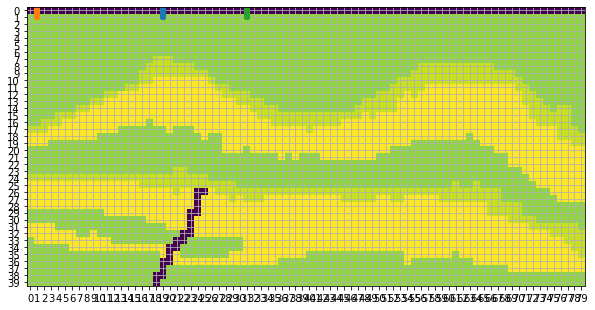

In [271]:
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
env = RewardDriller(env_config)

plt.figure(figsize=(10, 10))
plt.imshow(env.model, vmin=-10, vmax=2)

episodes = 1
for episode in range(1, episodes + 1):
#     print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = ppo.predict(state)
        state, reward, done, info = env.step(action)
#         print(f"    Reward: {reward}")

    for i in range(0,env.num_wells):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

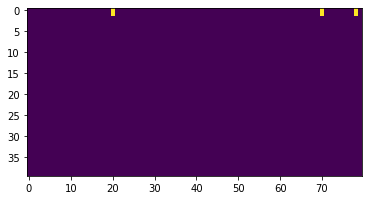

In [267]:
plt.imshow(env.state,)

## DQN

In [611]:
from stable_baselines3 import DQN

env = RewardDriller(env_config)

dqn = DQN("MlpPolicy", env, verbose=1)
dqn.learn(total_timesteps=100_000, log_interval=1_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.02     |
|    ep_rew_mean      | -305     |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 14291    |
|    time_elapsed     | 0        |
|    total_timesteps  | 5199     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.05     |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 14914    |
|    time_elapsed     | 0        |
|    total_timesteps  | 10356    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.49     |
|    ep_rew_mean      | -226   

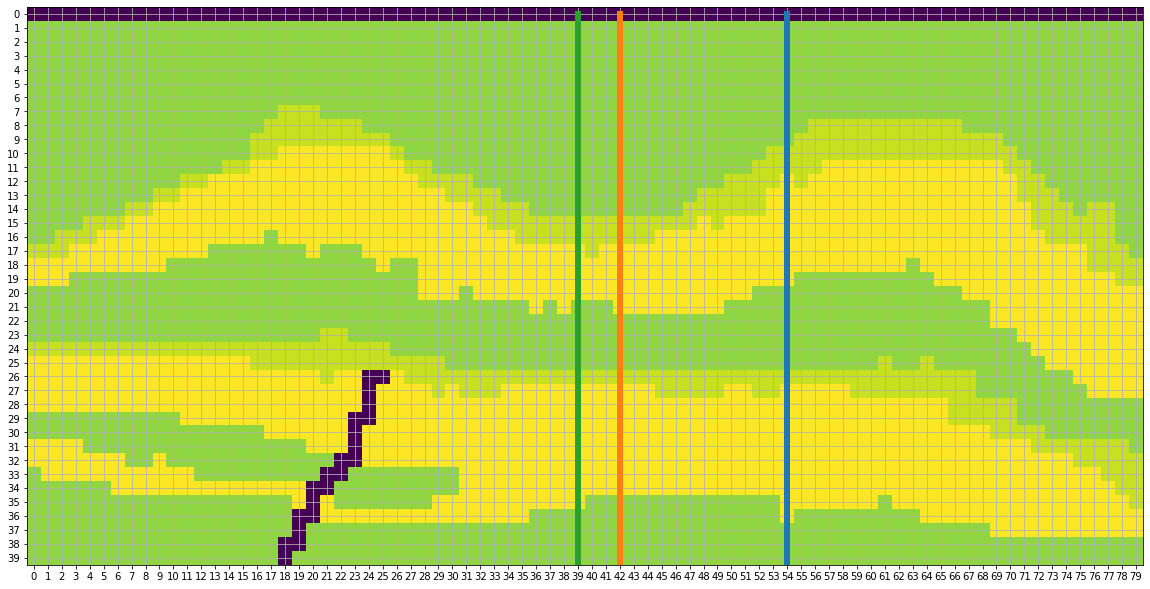

In [612]:
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
env = RewardDriller(env_config)

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

episodes = 1
for episode in range(1, episodes + 1):
#     print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = dqn.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)
#     print(f"    Reward: {reward}")



    for i in range(0,env.num_wells):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

## A2C

In [400]:
from stable_baselines3 import A2C

# More the number of wells, more time to train 
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=100, num_wells = 3, delim=",")

env = RewardDriller(env_config)

a2c = A2C("MlpPolicy", env, verbose=3)
a2c.learn(total_timesteps=100_000, log_interval=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 43.9      |
|    ep_rew_mean        | 6.85e+05  |
| time/                 |           |
|    fps                | 946       |
|    iterations         | 1000      |
|    time_elapsed       | 5         |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -0.037    |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 999       |
|    policy_loss        | 7.91      |
|    value_loss         | 2.05e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 89.3      |
|    ep_rew_mean        | 1.6e+06   |
| time/                 |           |
|    fps                | 960       |
|    iterations         | 2000  

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.14e+06  |
| time/                 |           |
|    fps                | 904       |
|    iterations         | 14000     |
|    time_elapsed       | 77        |
|    total_timesteps    | 70000     |
| train/                |           |
|    entropy_loss       | -3.07e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 13999     |
|    policy_loss        | -0        |
|    value_loss         | 7.83e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.14e+06  |
| time/                 |           |
|    fps                | 900       |
|    iterations         | 15000     |
|    time_elapsed       | 83        |
|    total_timesteps    | 75000     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 869       |
|    iterations         | 27000     |
|    time_elapsed       | 155       |
|    total_timesteps    | 135000    |
| train/                |           |
|    entropy_loss       | -1.19e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 26999     |
|    policy_loss        | -0        |
|    value_loss         | 4.1e+10   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 868       |
|    iterations         | 28000     |
|    time_elapsed       | 161       |
|    total_timesteps    | 140000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 118       |
|    ep_rew_mean        | 2.11e+06  |
| time/                 |           |
|    fps                | 850       |
|    iterations         | 40000     |
|    time_elapsed       | 235       |
|    total_timesteps    | 200000    |
| train/                |           |
|    entropy_loss       | -7.76e-07 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 39999     |
|    policy_loss        | -0        |
|    value_loss         | 9.12e+08  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 846       |
|    iterations         | 41000     |
|    time_elapsed       | 242       |
|    total_timesteps    | 205000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.12e+06  |
| time/                 |           |
|    fps                | 831       |
|    iterations         | 53000     |
|    time_elapsed       | 318       |
|    total_timesteps    | 265000    |
| train/                |           |
|    entropy_loss       | -9.34e-07 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 52999     |
|    policy_loss        | -0        |
|    value_loss         | 1.85e+04  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 831       |
|    iterations         | 54000     |
|    time_elapsed       | 324       |
|    total_timesteps    | 270000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 829       |
|    iterations         | 66000     |
|    time_elapsed       | 398       |
|    total_timesteps    | 330000    |
| train/                |           |
|    entropy_loss       | -5.54e-07 |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 65999     |
|    policy_loss        | -0        |
|    value_loss         | 1.31e+10  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 829       |
|    iterations         | 67000     |
|    time_elapsed       | 403       |
|    total_timesteps    | 335000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 828       |
|    iterations         | 79000     |
|    time_elapsed       | 476       |
|    total_timesteps    | 395000    |
| train/                |           |
|    entropy_loss       | -1.09e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 78999     |
|    policy_loss        | -0        |
|    value_loss         | 9.1e+08   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 828       |
|    iterations         | 80000     |
|    time_elapsed       | 482       |
|    total_timesteps    | 400000    |
| train/    

KeyboardInterrupt: 

In [ ]:
env = RewardDriller(env_config)

episodes = 10

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = a2c.predict(state)
        state, reward, done, info = env.step(action)
    print(f"    Reward: {reward}")

    for i in range(0,env.num_wells):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()